# Инференс модели RetinaNet

In [1]:
import os
import cv2
import time
import torch
import numpy as np
from config import NUM_CLASSES, DEVICE, CLASSES
from model import create_model

C:\Users\maks6\Desktop\Моя жизнь\pet-projects\БПЛА\git\retina_train\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = create_model(num_classes=NUM_CLASSES)
checkpoint = torch.load("outputs/best_model.pth", map_location=DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(DEVICE).eval()

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [3]:
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))

In [4]:
def inference_on_image(orig_image: np.ndarray, resize_dim=None, threshold=0.25):
    """
    Runs inference on a single image (OpenCV BGR or NumPy array).
    - resize_dim: if not None, we resize to (resize_dim, resize_dim)
    - threshold: detection confidence threshold
    Returns: processed image with bounding boxes drawn.
    """
    image = orig_image.copy()
    # Optionally resize for inference.
    if resize_dim is not None:
        image = cv2.resize(image, (resize_dim, resize_dim))

    # Convert BGR to RGB, normalize [0..1]
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    # Move channels to front (C,H,W)
    image_tensor = torch.tensor(image_rgb.transpose(2, 0, 1), dtype=torch.float).unsqueeze(0)
    start_time = time.time()
    # Inference
    with torch.no_grad():
        outputs = model(image_tensor)
    end_time = time.time()
    # Get the current fps.
    fps = 1 / (end_time - start_time)
    fps_text = f"FPS: {fps:.2f}"
    # Move outputs to CPU numpy
    outputs = [{k: v.cpu() for k, v in t.items()} for t in outputs]
    boxes = outputs[0]["boxes"].numpy()
    scores = outputs[0]["scores"].numpy()
    labels = outputs[0]["labels"].numpy().astype(int)

    # Filter out boxes with low confidence
    valid_idx = np.where(scores >= threshold)[0]
    boxes = boxes[valid_idx].astype(int)
    labels = labels[valid_idx]

    h_orig, w_orig = orig_image.shape[:2]
    
    # If we resized for inference, rescale boxes back to orig_image size
    if resize_dim is not None:
        h_orig, w_orig = orig_image.shape[:2]
        h_new, w_new = resize_dim, resize_dim
        # scale boxes
        boxes[:, [0, 2]] = (boxes[:, [0, 2]] / w_new) * w_orig
        boxes[:, [1, 3]] = (boxes[:, [1, 3]] / h_new) * h_orig

    # Draw bounding boxes
    for box, label_idx in zip(boxes, labels):
        class_name = CLASSES[label_idx] if 0 <= label_idx < len(CLASSES) else str(label_idx)
        color = COLORS[label_idx % len(COLORS)][::-1]  # BGR color
        cv2.rectangle(orig_image, (box[0], box[1]), (box[2], box[3]), color, 5)
        cv2.putText(orig_image, class_name, (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 3)
        cv2.putText(
            orig_image,
            fps_text,
            (int((w_orig / 2) - 50), 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.8,
            (0, 255, 0),
            2,
            cv2.LINE_AA,
        )
    return orig_image, fps

In [5]:
img = cv2.imread("./data/test/img/1029.jpg")

In [6]:
img_predict = inference_on_image(img)

In [7]:
from matplotlib import pyplot as plt

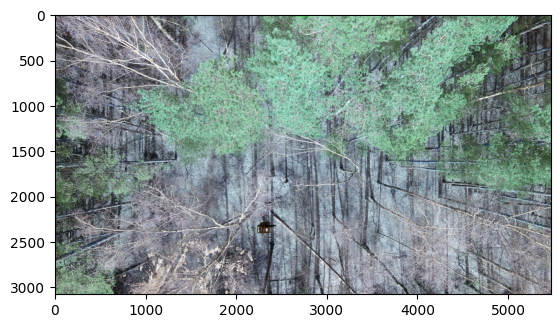

In [8]:
plt.imshow(img_predict[0])